In [46]:
import torch
torch.__version__

'2.3.0.dev20240227'

In [47]:
import numpy as np
# import datetime
import h5py
import pandas as pd

import torch.optim as optim
import torch.nn as nn
# import torch.functional as F
# from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import Dataset
# from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

In [48]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [49]:
device

device(type='mps')

In [50]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]  

In [51]:
# dataset class

class CoilDataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['coil-100']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[str(index)+'.png'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        return torch.tensor(img, device=device, dtype=torch.float32).\
            permute(2,0,1).view(1,3,128,128) / 255.0
    
    def plot_image(self, index):
        img = np.array(self.dataset[str(index)+'.png'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')

    # def __getitem__(self, index):
    #     if (index >= len(self.dataset)):
    #       raise IndexError()
    #     img = np.array(self.dataset[str(index)+'.png'])
    #     return torch.tensor(img, device=device, dtype=torch.float32) / 255.0
    
    # def plot_image(self, index):
    #     plt.imshow(np.array(self.dataset[str(index)+'.png']), interpolation='nearest')

In [52]:
orih5 = r"/Users/narju/Documents/code/educative/retouch/coil-100-originals.h5py"
wtr5 = r"/Users/narju/Documents/code/educative/retouch/coil-100-watermarked.h5py"

In [53]:
f = h5py.File(orih5)

In [54]:
list(f.keys())

['coil-100']

In [55]:
with h5py.File(orih5,'r') as f_obj:
    print("datasets: ")
    for dset in f_obj:
        print(dset)
    print("keys: ")
    for group in f_obj.keys():
        print(group)

    dataset = f_obj['coil-100']

datasets: 
coil-100
keys: 
coil-100


In [56]:
dataset.name

(128, 128, 3)
(128, 128, 3)


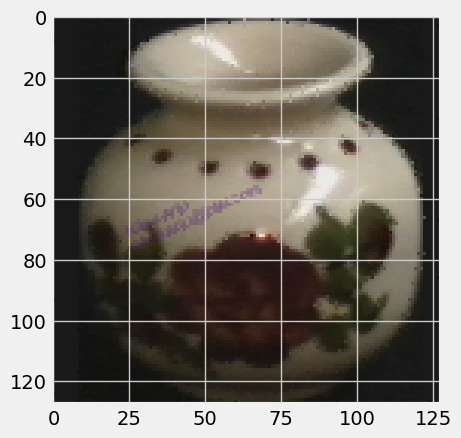

In [57]:
with h5py.File(orih5, 'r') as f_obj:
    dataset = f_obj['coil-100']
    # print("values: ", dataset[:])
    image = np.array(dataset['35.png'])
    print(image.shape)
    # plt.imshow(image, interpolation='none')

with h5py.File(wtr5, 'r') as f_obj:
    dataset = f_obj['coil-100']
    # print("values: ", dataset[:])
    image = np.array(dataset['35.png'])
    print(image.shape)
    plt.imshow(image, interpolation='none')

In [58]:
coil_dataset = CoilDataset(orih5)
watermarked_dataset = CoilDataset(wtr5)

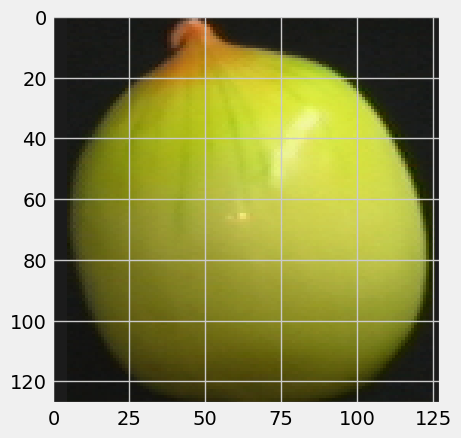

In [59]:
coil_dataset.plot_image(4105)

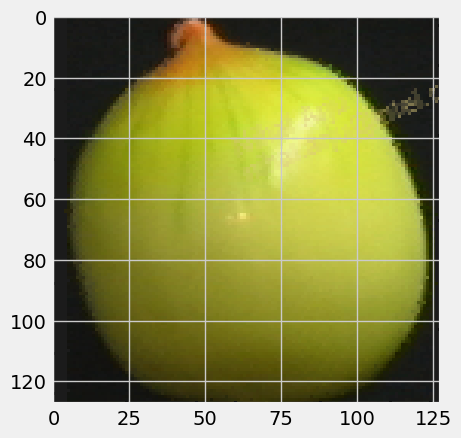

In [60]:
watermarked_dataset.plot_image(4105)

In [61]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [62]:
# # discriminator class

# class Discriminator(nn.Module):
    
#     def __init__(self):
#         # initialise parent pytorch class
#         super().__init__()
        
#         # define neural network layers
#         self.model = nn.Sequential(
#             # expect input of shape (1,3,128,128)
#             nn.Conv2d(3, 256, kernel_size=8, stride=2),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(256, 256, kernel_size=8, stride=2),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(256, 3, kernel_size=8, stride=2),
#             nn.LeakyReLU(0.2),
            
#             View(3*10*10),
#             nn.Linear(3*10*10, 1),
#             nn.Sigmoid()
#         )
        
#         # create loss function
#         self.loss_function = nn.BCELoss()

#         # create optimiser, simple stochastic gradient descent
#         self.optimiser = torch.optim.Adam(self.parameters(), lr=0.1e-4)

#         # counter and accumulator for progress
#         self.counter = 0;
#         self.progress = []

#         pass
    
    
#     def forward(self, inputs):
#         # simply run model
#         return self.model(inputs)
    
    
#     def train(self, inputs, targets):
#         # calculate the output of the network
#         outputs = self.forward(inputs)
        
#         # calculate loss
#         loss = self.loss_function(outputs, targets)

#         # increase counter and accumulate error every 10
#         self.counter += 1;
#         if (self.counter % 10 == 0):
#             self.progress.append(loss.item())
#             pass
#         if (self.counter % 1000 == 0):
#             print("counter = ", self.counter)
#             pass

#         # zero gradients, perform a backward pass, update weights
#         self.optimiser.zero_grad()
#         loss.backward()
#         self.optimiser.step()

#         pass
    
    
#     def plot_progress(self):
#         df = pd.DataFrame(self.progress, columns=['loss'])
#         df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
#         pass
    
#     pass

In [63]:
# discriminator class
# this one uses fewer parameters but also initially smaller conv filter

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 3, kernel_size=8, stride=2),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2),
            
            # nn.Conv2d(256, 3, kernel_size=8, stride=2),
            # nn.LeakyReLU(0.2),
            
            View(3*60*60),
            nn.Linear(3*60*60, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=1e-4)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 100 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [64]:
# D = Discriminator()
# D.to(device)
# print(D)

In [65]:
# %%time
# # test discriminator can separate real data from random noise
# # move model to cuda device

# for epoch in range(10):
#     cntr = 0
#     for image_data_tensor, wtr_data_tensor in zip(coil_dataset, watermarked_dataset):
#         # real data
#         D.train(image_data_tensor, torch.tensor([1.0], device=device, dtype=torch.float32))
#         D.train(wtr_data_tensor, torch.tensor([0.0], device=device, dtype=torch.float32))
#         cntr += 1
#         if cntr > 2e8:
#             break

        

# Generator Network 

In [66]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.block = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 32, kernel_size=2, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.05),

            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

        self.model = nn.Sequential(
            self.block,
            self.block
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=1e-4)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets) + ((inputs - g_output)**2).sum()

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 100 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [67]:
G = Generator()
G.to(device)

Generator(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
    (3): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
  )
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.05)
      (3): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(1, 1))
      (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sigmoid()
    )
    (1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [68]:
image = watermarked_dataset[4105]
# D.to(device)
output = G(image)
print(output.shape)

torch.Size([1, 3, 128, 128])


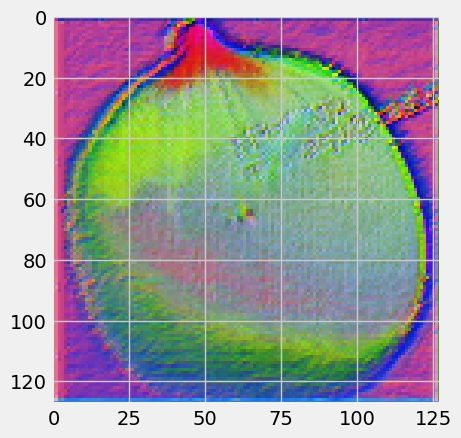

In [69]:
img = output.squeeze().permute(1,2,0).detach().cpu().numpy()
plt.imshow(img)

In [70]:
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

Generator(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05)
    (3): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
  )
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.05)
      (3): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(1, 1))
      (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sigmoid()
    )
    (1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [71]:
%%time 

for epoch in range(30):
    print("epoch= ", epoch)

    cntr = 0
    for image_data_tensor, wtr_data_tensor in zip(coil_dataset, watermarked_dataset):
      # train discriminator on true
      D.train(image_data_tensor, torch.tensor([1.0], device=device, dtype=torch.float32))
      D.train(wtr_data_tensor, torch.tensor([0.0], device=device, dtype=torch.float32))
      
      # train generator
      G.train(D, wtr_data_tensor, torch.tensor([1.0], device=device, dtype=torch.float32))
      # G.train(D, wtr_data_tensor, torch.tensor([1.0], device=device, dtype=torch.float32))
      cntr += 1
      if cntr > 2e10:
        break


epoch=  0
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
epoch=  1
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
epoch=  2
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
epoch=  3
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000


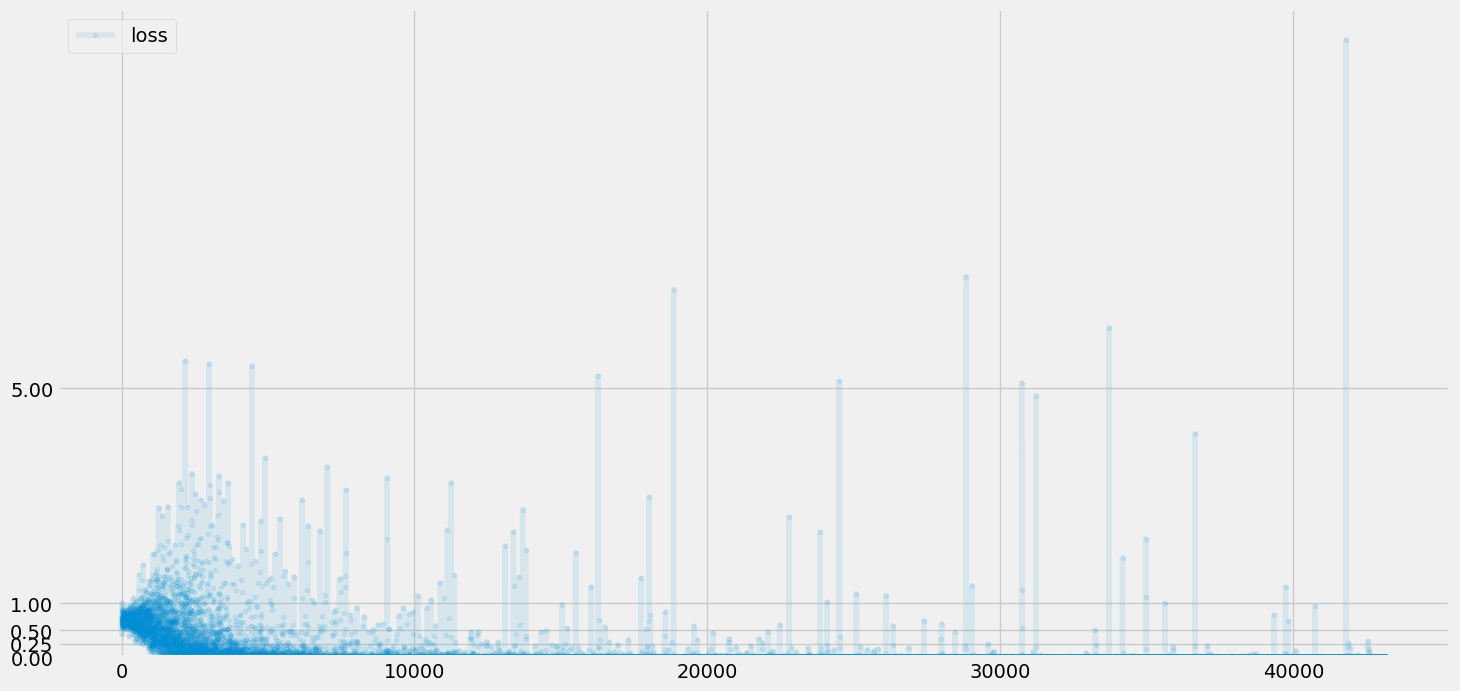

In [72]:
D.plot_progress()

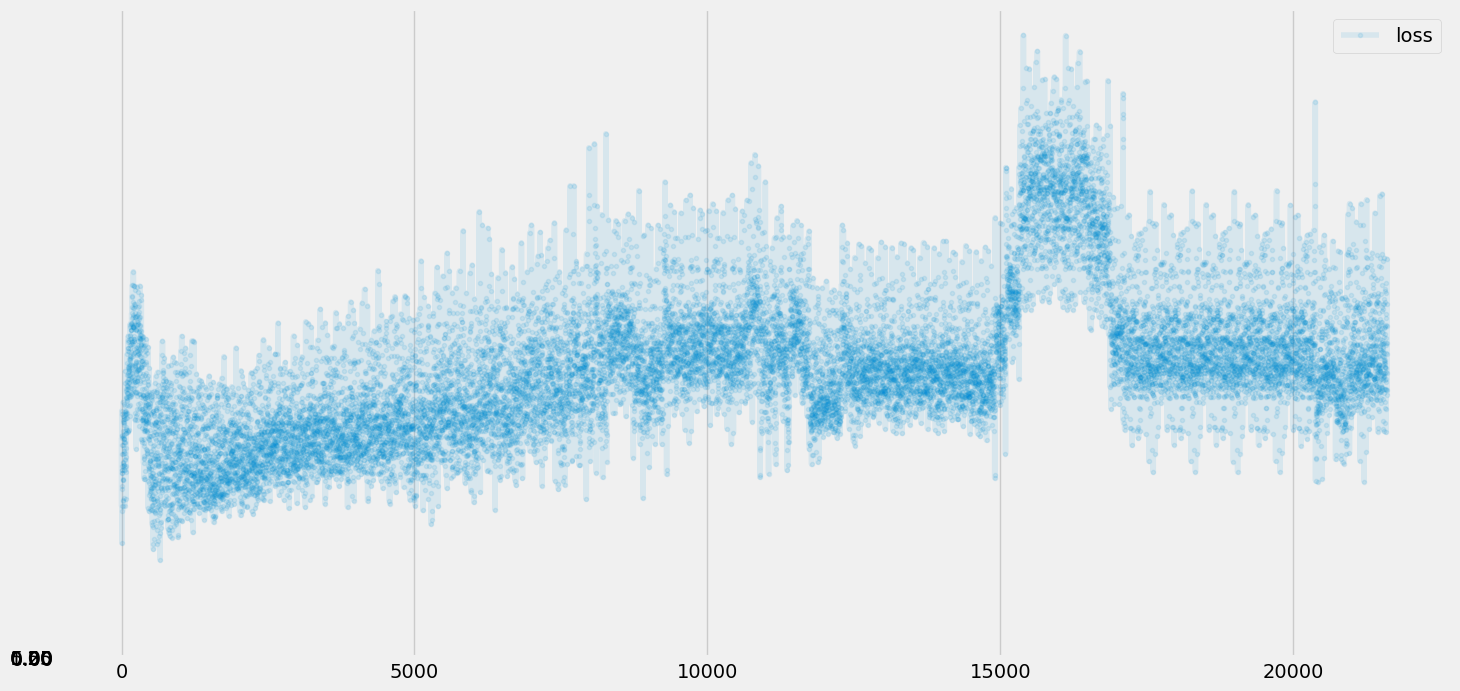

In [73]:
G.plot_progress()

In [74]:
image = coil_dataset[4102]
print(D(image))
image = watermarked_dataset[4102]
print(D(image))

tensor([1.], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([0.0001], device='mps:0', grad_fn=<SigmoidBackward0>)


torch.Size([1, 3, 128, 128])


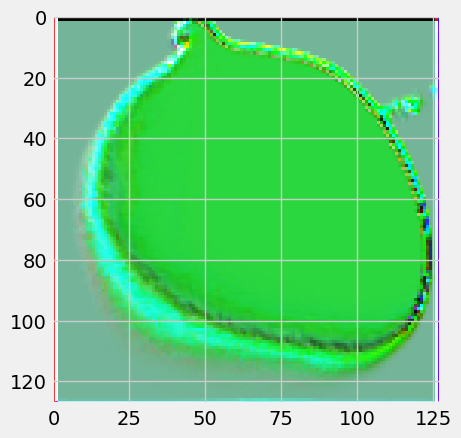

In [75]:
image = watermarked_dataset[4105]
# D.to(device)
output = G(image)
print(output.shape)
img = output.squeeze().permute(1,2,0).detach().cpu().numpy()
plt.imshow(img)

In [76]:
image.max()

tensor(0.9804, device='mps:0')